<a href="https://colab.research.google.com/github/Cool-buddies-of-ENEL645/OurAwesomeFinalProject/blob/main/Densenet_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.densenet.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.densenet.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


In [7]:
model_name_it = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_it_50ep.h5"
model_name_ft = "/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_ft_50ep.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [6]:
with open('/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_it_50ep.h5', 'rb') as f:
    x = pickle.load(f)
# pickle.load("/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/garbage_classifier_en_b0_it_50ep.h5")

UnpicklingError: ignored

In [8]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)


out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

29097984/29084464 [==============================] - 0s 0us/step
Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 7,299,652
Trainable params: 262,148
Non-trainable params: 7,037,504
_________________________________________________________________
None


In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=50, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/50
81/81 [==============================] - 1031s 13s/step - loss: 0.6932 - accuracy: 0.7463 - val_loss: 0.5815 - val_accuracy: 0.7854 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 113s 1s/step - loss: 0.4062 - accuracy: 0.8502 - val_loss: 0.5535 - val_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 114s 1s/step - loss: 0.3651 - accuracy: 0.8640 - val_loss: 0.5147 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 112s 1s/step - loss: 0.3230 - accuracy: 0.8823 - val_loss: 0.5132 - val_accuracy: 0.8112 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 111s 1s/step - loss: 0.3078 - accuracy: 0.8825 - val_loss: 0.5067 - val_accuracy: 0.8228 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 112s 1s/step - loss: 0.2860 - accuracy: 0.8875 - val_loss: 0.4844 - val_accuracy: 0.8424 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] 

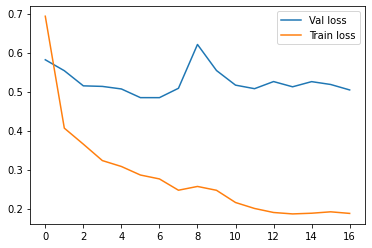

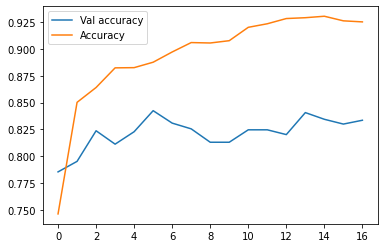

In [11]:
it_file = open("/content/drive/My Drive/Colab Notebooks/Garbage-Classification/it_history.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

In [ ]:
it_file


<_io.BufferedWriter name='/content/drive/My Drive/Colab Notebooks/Garbage-Classification/it_history.pkl'>

In [12]:
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 7,299,652
Trainable params: 7,216,004
Non-trainable params: 83,648
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 138s 2s/step - loss: 0.2362 - accuracy: 0.9083 - val_loss: 0.5125 - val_accuracy: 0.8085 - lr: 1.0000e-0

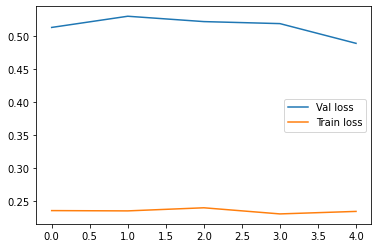

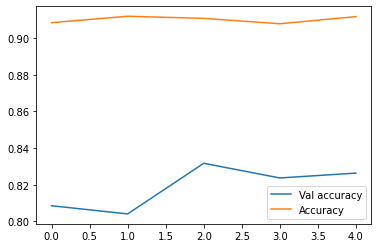

In [13]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

ft_file = open("/content/drive/My Drive/Colab Notebooks/Garbage-Classification/ft_history.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

In [19]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = '/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Test',
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [14]:
import os
def main():
    path = '/content/drive/My Drive/Colab Notebooks/Garbage-Classification/Garbage/Test/Take-to-recycle/'
    for count, filename in enumerate(os.listdir(path)):
        print(filename)
        [a, b] = filename.split(".")
        new_name = a + ".png"
        # print(dst)
        src = path + filename
        dst = path + new_name
        os.rename(src, dst)



# Driver Code
if __name__ == '__main__':
    # Calling main() function
    main()

battery740.png
battery745.png
battery746.png
battery747.png
battery748.png
battery749.png
battery75.png
battery751.png
battery753.png
battery755.png
battery757.png
battery758.png
battery759.png
battery760.png
battery763.png
battery766.png
battery767.png
battery768.png
battery769.png
battery77.png
battery770.png
battery771.png
battery772.png
battery773.png
battery774.png
battery775.png
battery776.png
battery777.png
battery778.png
battery779.png
battery78.png
battery780.png
battery781.png
battery782.png
battery783.png
battery784.png
battery785.png
battery786.png
battery787.png
battery789.png
battery788.png
battery79.png
battery790.png
battery791.png
battery792.png
battery793.png
battery794.png
battery795.png
battery796.png
battery797.png
battery798.png
battery799.png
battery8.png
battery80.png
battery800.png
battery801.png
battery802.png
battery803.png
battery804.png
battery805.png
battery806.png
battery807.png
battery809.png
battery808.png
battery81.png
battery810.png
battery811.png
bat

In [20]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(test_generator)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate(test_generator)

13/13 [==============================] - 18s 1s/step - loss: 0.6542 - accuracy: 0.7819


[0.6541882157325745, 0.7819082736968994]

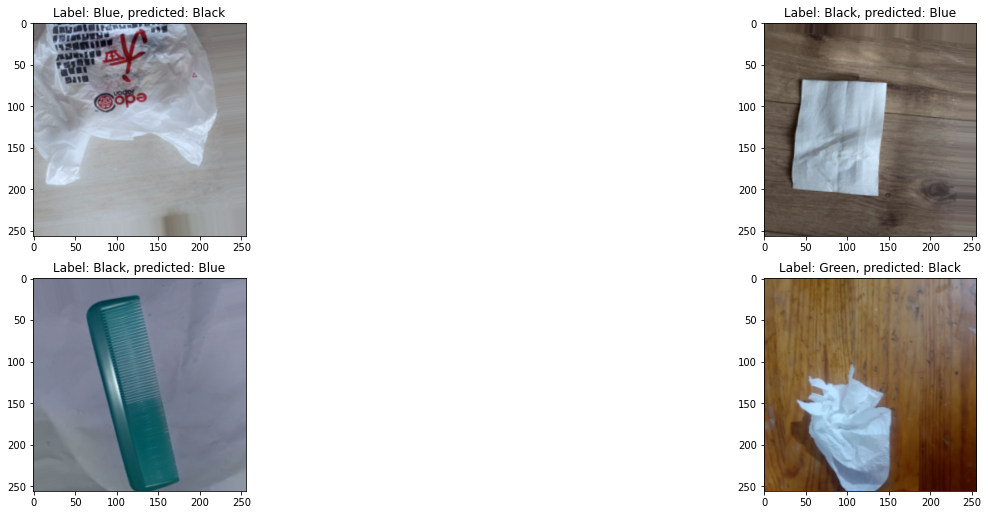

In [21]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 4, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

def print_report_conf_matrix(model):
  print("--------------------------------------------------------")
  print(model.name)
  print("--------------------------------------------------------")
  Ypred = model.predict(Xtest).argmax(axis = 1)
  report = classification_report(Ytest, Ypred)
  print(report)
  plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)


--------------------------------------------------------
model
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.53      0.61        19
           1       0.52      0.69      0.59        16
           2       1.00      0.88      0.93        16
           3       0.87      1.00      0.93        13

    accuracy                           0.75        64
   macro avg       0.78      0.77      0.77        64
weighted avg       0.77      0.75      0.75        64

Confusion matrix, without normalization


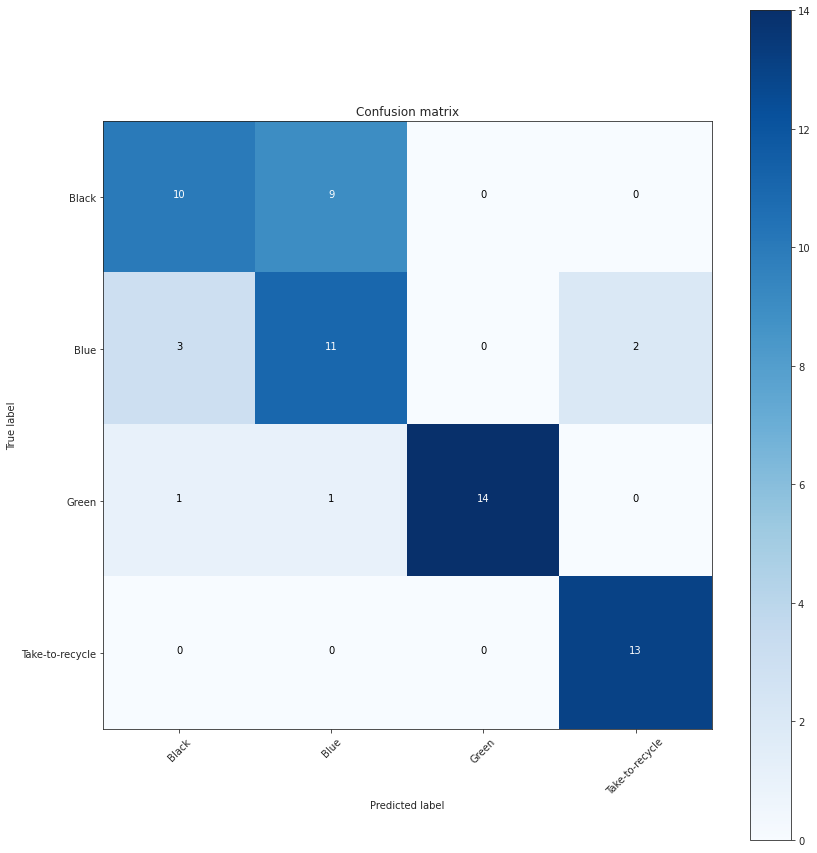

In [23]:
print_report_conf_matrix(model)